# Group 34: STAT301 Final Report
### Predicting House Sale Price in King County, USA

**Group Members**: 
Alexander Geyer, Linda Zhang, Sana Shams, Yilin Long

In [1]:
# loading all relevant libraries
library(readr)
library(broom)
library(tidyverse)
library(tidymodels)
library(repr)
library(cowplot)
library(GGally)
library(infer)
library(gridExtra)
library(glmnet)
library(car)

install.packages("ggplot2")
library(ggplot2)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ purrr     1.0.2
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ dials        1.2.0     ✔ rsample      1.2.0
✔ infer        1.0.5     ✔ tune         1.1.2
✔ modeldata    1.2.0     ✔ workflows    1.1.3
✔ parsnip      1.1.1     ✔ workflowsets 1.0.1
✔ recipes      1.0.8     ✔ yardstick    1.2.0

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  

# Introduction
The housing market is a dynamic and complex system influenced by various factors, making accurate price prediction challenging yet crucial for both buyers and sellers. Understanding the relationships between the features of a house and its sale price can provide valuable insights into the market trends and aid in making informed decisions in domains such as the real estate market, government tax assessment, and insurance. 

### Data
The dataset for this project is[House Sales in King County, USA](https://www.kaggle.com/datasets/harlfoxem/housesalesprediction/code) from Kaggle. This dataset contains house sale prices for King County for the years 2014 to 2015. The dataset was found and accessed through Kaggle, but it is originally from the [Geographic Information System open source center for King County](https://gis-kingcounty.opendata.arcgis.com/datasets/zipcodes-for-king-county-and-surrounding-area-shorelines-zipcode-shore-area/explore?location=47.486709%2C-121.477600%2C8.00&showTable=true). The methods of collection is not disclosed.Through the analysis of this dataset, we aim to explore the predictive performance of different linear regression models to refine our understanding of the factors driving house sale prices in King County during 2014-2015. We will be focusing on prediction for this project.

Given that our dataset has 21,613 observations, and 21 different features, narrowing down the features will improve the efficacy of our analysis in terms of computational power required, relevance of features, and generalizability (Jovic et al., 2015). When determining the various feature selection methods, we selected both forward selection and backward selection wrapper methods for sequential feature evaluation. Both selection methods are explored because depending on the feature interactions of the unique dataset, the number of relevant features, the number of overall features, and the variation among each feature, backward feature selection may perform better than forward feature selection, and vice versa (Chan et al., 2010). A particular concern in our dataset is bias and variance between the range of values for individual features. Moreover, in cases where the number of observations is higher than the number of features, there is the possibility of multicollinearity among our features, in which case Lasso regularization is outperformed by Ridge regularization (Zou & Hastie, 2003). Thus, we will also examine the performance of Elastic Net Regression, which strikes a balance between the L1 and L2 penalties employed by Lasso and Ridge regularization, respectively. 

### Questions

The questions we will be examining are: 
1. Out of all the features provided in the dataset, which group of explanatory variables form the best linear regression model for predicting the response variable, price?
2. Out of forward selection, backward selection, and elastic net regression, which model selection method yields the best-performing linear regression model for predicting the response variable, price?


# Methods and Results

## Exploratory Data Analysis

In [2]:
# reading data from the web into R

data_url = "https://raw.githubusercontent.com/sanash43/STAT301/main/kc_house_data.csv"

house_data<-read_csv(url(data_url))

head(house_data)

Rows: 21613 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): id
dbl  (19): price, bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterf...
dttm  (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,⋯,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7129300520,2014-10-13,221900,3,1.00,1180,5650,1,0,0,⋯,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
6414100192,2014-12-09,538000,3,2.25,2570,7242,2,0,0,⋯,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
5631500400,2015-02-25,180000,2,1.00,770,10000,1,0,0,⋯,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2487200875,2014-12-09,604000,4,3.00,1960,5000,1,0,0,⋯,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
1954400510,2015-02-18,510000,3,2.00,1680,8080,1,0,0,⋯,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
7237550310,2014-05-12,1225000,4,4.50,5420,101930,1,0,0,⋯,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930


In [3]:
# Summary of data types 

data_types <- sapply(house_data, typeof)
data_types

id          date         price      bedrooms     bathrooms 
  "character"      "double"      "double"      "double"      "double" 
  sqft_living      sqft_lot        floors    waterfront          view 
     "double"      "double"      "double"      "double"      "double" 
    condition         grade    sqft_above sqft_basement      yr_built 
     "double"      "double"      "double"      "double"      "double" 
 yr_renovated       zipcode           lat          long sqft_living15 
     "double"      "double"      "double"      "double"      "double" 
   sqft_lot15 
     "double"

|feature | data type | additional information |
|---------|-----------|---------------------------------|
| id | character | unique for each house, should not be used for any regression |
| date | datetime |  in format: yearmonthdate, could potentially extract the month sold for seasonal sales insight, but year will be dismissed as this dataset only covers houses sold in 2014-2015 |
| price | double | can be treated as a numerical, continuous variable|
| bedrooms | double  | ordinal |
| bathrooms | double | ordinal, note: 0.5 bathroom indicates no bathtub/shower |
| sqft_living | double | continuous numerical variable |
| sqft_lot | double | continuous numerical variable |
| floors | double | ordinal |
| waterfront | double | binary -- a house with a waterfront view is assigned a value of 1, and a house without a watefront view has a value of 0 |
| view | double | ordinal, an index from 0 to 4 of how good the view of the property|
| condition | double | ordinal, building condition is assigned according to age and grade with the following categories: 1 Poor-Worn Out, 2 Fair-Badly Worn, 3 Average, 4 Good, 5 Very Good |
| grade | double | ordinal, represents the construction quality of the the building from 1 falls short of minimum building standards to 13 custom designed and built, highest quality materials and engineering. 7 is the average grade of construction and design grade|
| sqft_above | double | can be treated as a numerical, continuous variable |
| sqft_basement | double | can be treated as a numerical, continuous variable |
| yr_built | double | can be treated as a numerical, continuous variable |
| yr_renovated | double | can be treated as a numerical, continuous variable|
| zipcode | double | (almost) unique value per house, should not be treated as a continuous numerical variable |
| lat | double | continuous numerical variable |
| long | double | continuous numerical variable |
| sqft_living15 | double | continouos numeric variable |
| sqft_lot15 | double | continuous numeric variable |

In [4]:
# Checking for NaN values

na_counts <- colSums(is.na(house_data))
na_counts

id          date         price      bedrooms     bathrooms 
            0             0             0             0             0 
  sqft_living      sqft_lot        floors    waterfront          view 
            0             0             0             0             0 
    condition         grade    sqft_above sqft_basement      yr_built 
            0             0             0             0             0 
 yr_renovated       zipcode           lat          long sqft_living15 
            0             0             0             0             0 
   sqft_lot15 
            0

#### Checking for Multicollinearity


#### HeatMap Analysis

**Removing certain variables + justification**

For the heatmap analysis, we will be removing the following variables for the sake of clarity:

* **id**: this is a unique value for each observation and probably will not be helpful for a regression model
* **date**: a date time object cannot be passed into a heatmap

In [5]:
# making a melted correlation matrix to examine pairwise correlation coefficients between input variables 

corr_matrix <- house_data %>%
    select(-c(id, date)) %>%
    cor() %>%
    as.data.frame() %>%
    rownames_to_column("var1") %>%
    pivot_longer(-var1, names_to = "var2", values_to = "corr")

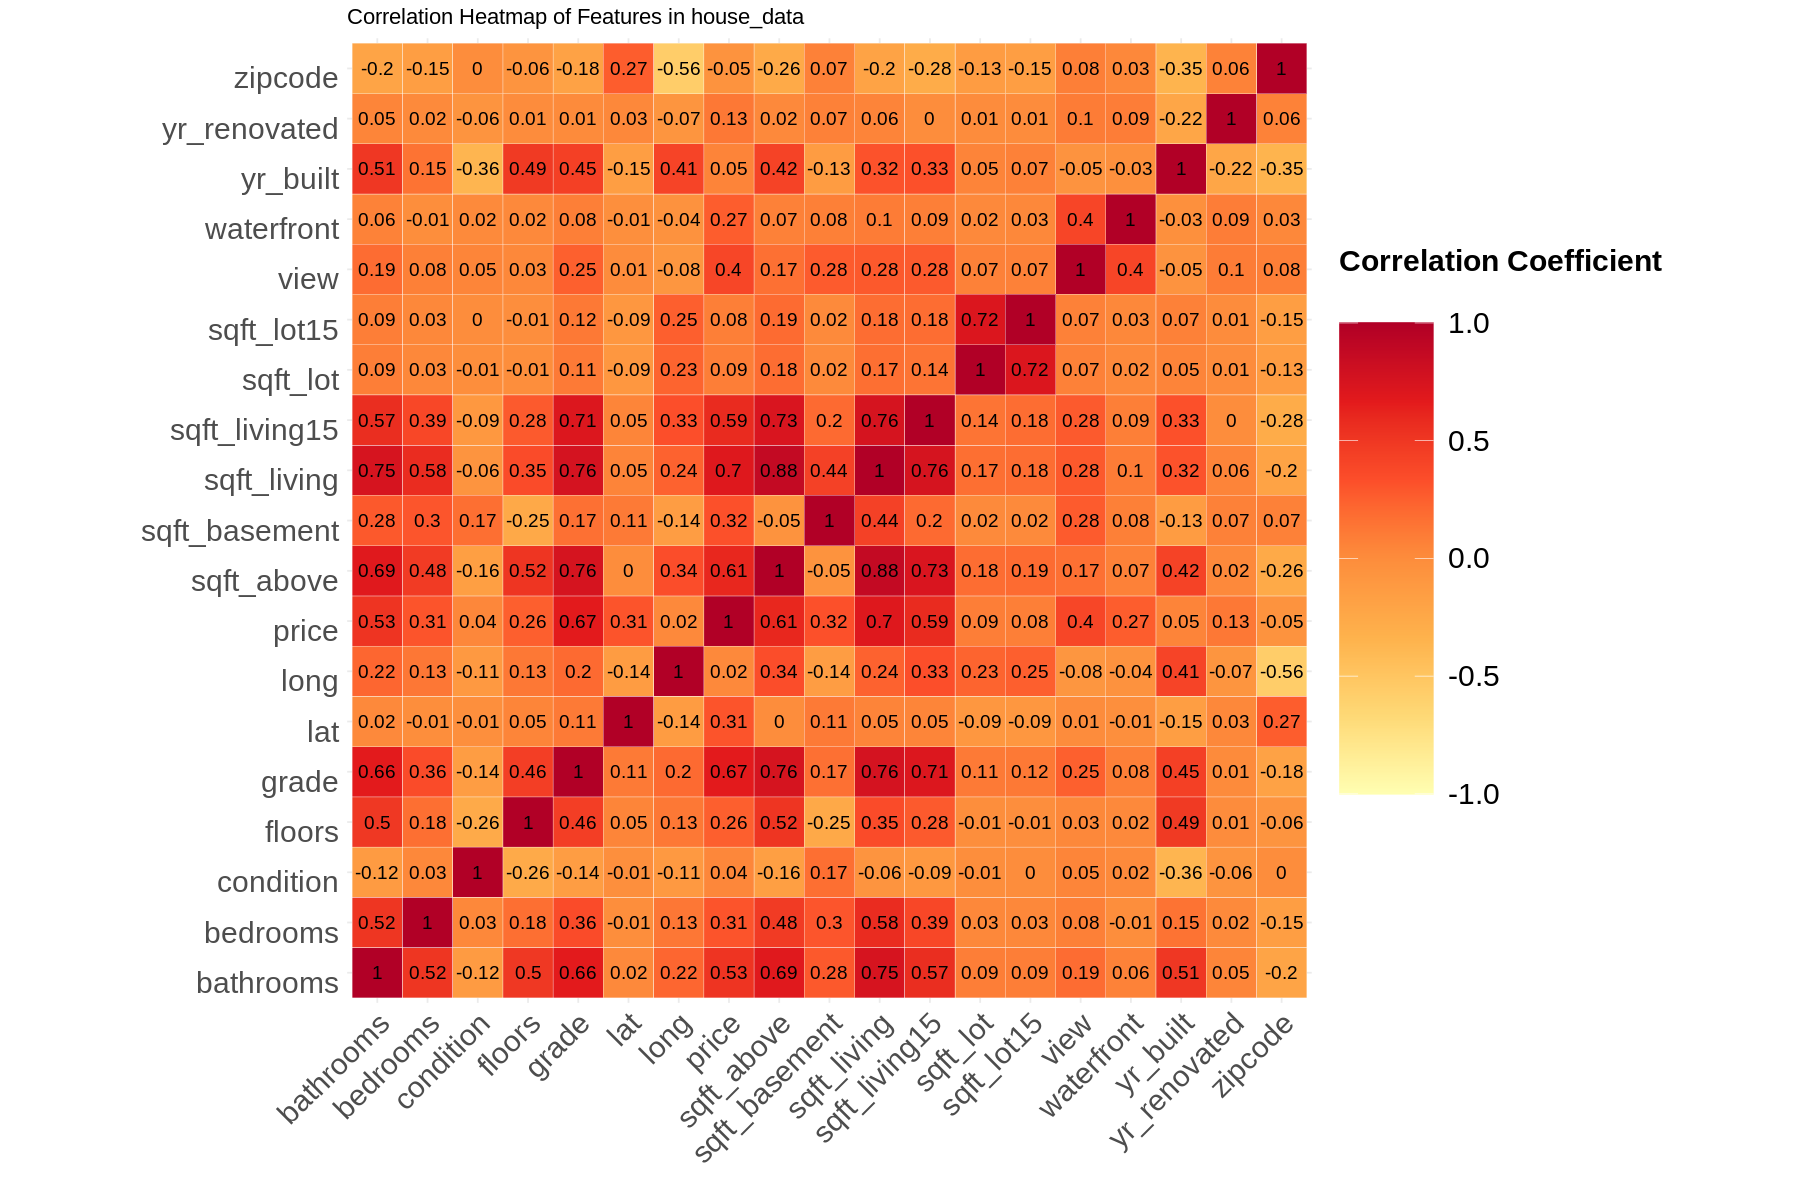

In [6]:
# visualizing correlations using a heatmap

options(repr.plot.width = 15, repr.plot.height = 10)

heat_map <- corr_matrix %>%
    ggplot(aes(var1, var2)) +
    geom_tile(aes(fill = corr), color = "white") +
    scale_fill_distiller("Correlation Coefficient \n",
                         palette = "YlOrRd",
                         direction = 1, limits = c(-1, 1)) +
    labs(x = "", y = "") +
    ggtitle("Correlation Heatmap of Features in house_data") +
    theme_minimal() +
    theme(
        axis.text.x = element_text(
            angle = 45, vjust = 1,
            size = 18, hjust = 1
        ),
        axis.text.y = element_text(
            vjust = 1,
            size = 18, hjust = 1
        ),
        legend.title = element_text(size = 18, face = "bold"),
        legend.text = element_text(size = 18),
        legend.key.size = unit(2, "cm")) +
    coord_fixed() +
    geom_text(aes(var2, var1, label = round(corr, 2)), color = "black", size = 4)

heat_map

From this heatmap, it is clear that some explanatory variables have a high correlation with other explanatory variables. To further examine this, we will check for multicollinearity by examining the variance inflation factor.

In [7]:
# creating a small data subset. The entire dataset is too large and causes kernel to crash

set.seed(123)

# collecting a random sample of 5000 houses since the full dataset is too large (20000, causes kernel crash)

house_sample <- house_data[sample(nrow(house_data), 1000), ]

# removing id and date (these are not learnable features as id is unique to each house and we are not performing a time series analysis)
house_sample <- subset(house_sample, select = -c(id, date))


Using the Variance Inflation factor produces an error because there are aliased coefficients in the model, which vif() canont handle. Aliasing occurs when predictor variables are perfectly or nearly perfectly correlated, resulting in linear dependencies in the model matrix. To identify the aliased coefficients, we employ the alias() function.

In [8]:
# fitting a dummy test model to check for multicollinearity using variance inflaction factor

mlc_model <- lm(price ~ ., data = house_sample)

alias_coeff <- alias(mlc_model, complete = TRUE)

alias_coeff

Model :
price ~ bedrooms + bathrooms + sqft_living + sqft_lot + floors + 
    waterfront + view + condition + grade + sqft_above + sqft_basement + 
    yr_built + yr_renovated + zipcode + lat + long + sqft_living15 + 
    sqft_lot15

Complete :
              (Intercept) bedrooms bathrooms sqft_living sqft_lot floors
sqft_basement  0           0        0         1           0        0    
              waterfront view condition grade sqft_above yr_built yr_renovated
sqft_basement  0          0    0         0    -1          0        0          
              zipcode lat long sqft_living15 sqft_lot15
sqft_basement  0       0   0    0             0        


From this, we can see that sqft_basement is perfectly collinear iwth sqft_above because the coefficient for this combination is -1. This indicates that the variables sqft_basement and sqft_above are linearly dependent, and their coefficients cannot be uniquely estimated in the model, resulting in collinearity issues. sqft_living and sqft_basement are also perfectly colinear, as they have a coefficient of 1. 

**let's decide as a group what kind of visualization we want because I think a lot of us did something similar...add visualizations after discussing as a group.**

# Methods: Plan

In order to address our two questions, we will explore the model generated by the following methods: 
* Forward Selection
* Backward Selection
* Elastic Net Regression

Across all three model selection methods, the following steps will be consistent: 
1. **Subset generation:**
    
    Creating a train and test set from a subset of the dataset as the full dataset is too large and cuases Kernel to crash.
2. **Deriving the linear regression:**

    This includes determining the stopping criterion to obtain the model with the best root mean squared error.
    
3. **Evaluating the model**: 

    The model's performance will be evaluated using cross validation on the train set. The model will also be evaluated on its performance in comparison to the Null Model. Moreover, we will check each model for heteroskedasticity to evaluate the assumptions made when imposing a linear regression on the data.
    
Once the *final model* with the best fit has been determined, we will deploy it to form predictions on the test set, *once*. We will examine its deployment performance using the Root Mean Squared Prediction Error. 

# Methods: Results

In [9]:
# Setting the train and test subsets

# setting train and test sets

set.seed(123)

# collecting a random sample of 5000 houses since the full dataset is too large (20000, causes kernel crash)

house_sample <- house_data[sample(nrow(house_data), 5000), ]

# removing id and date (these are not learnable features as id is unique to each house and we are not performing a time series analysis)
house_sample <- subset(house_sample, select = -c(id, date))

training_housing <- house_sample %>%
    
    sample_frac(0.6)

testing_housing <- house_sample %>%
    setdiff(training_housing)

# building matrix and vector required 'glment'

housing_X_train <- model.matrix(object = price ~ .,
                                data = training_housing)[, -1]

housing_y_train <- training_housing[[ "price"]]

housing_X_test <- model.matrix(object = price ~ .,
                                data = testing_housing)[, -1]

housing_y_test <- testing_housing[[ "price"]]

### Elastic Net Regression

In this section, given that multicolinearity is an issue in our data, we will compare different regularization methods for model selection. The regularization methods are: Lasso (L1 penalization), Ridge (L2 penalization), and Elastic Net Regression (L1 and L2 penalization). 

We will focus on investigating Elastic Net Regression as it combines the addvantages of Ridge and Lasso Regression. Like Ridge regression, Elastic Net can handle multicollinearity, and like Lasso, it can also perform feature selection as it has a sparsity-inducing property. Furthermore, we will be exploring a range of lambda values to minimizing the RMSE of the fitted model.

**depending on word count after all other sections, I can write more about elastic net, TA said if we're tight on word count then it won't be necessary to discuss the method in detail**.

In [10]:
# Here, various alpha values are compared for their root mean squared error value to gauge which method results in the best linear regression fit

set.seed(123)

# Applying Elastic Net Regression, values include the results of Ridge and Lasso regression

fits <- list()

for (i in 0:10) {
    fit.name <- paste0("alpha", i/10)
    
    fits[[fit.name]] <- 
        cv.glmnet(housing_X_train, housing_y_train, type.mesure='mse', alpha = i/10,
                  family = "gaussian")
    }

elastinc_net_results <- data.frame()


for (i in 0:10) {
    fit.name <- paste0("alpha", i/10)
    
    predicted <- predict(fits[[fit.name]],
                         s = fits[[fit.name]]$lambda.1se, newx = housing_X_test) 
    # Note: in class materials, when examining Ridge regresion, we use $lambda.min, 
    #      however we will use lambda.1se for all regularizations so we can fairly compare
    
    rmse <- sqrt(mean((predicted - housing_y_test)^2))
    
    temp <- data.frame(alpha = i/10, rmse = rmse, fit.name = fit.name)
    
    elastinc_net_results <- rbind(elastinc_net_results, temp)
    
    }


elastinc_net_results

alpha,rmse,fit.name
<dbl>,<dbl>,<chr>
0.0,207548.4,alpha0
0.1,209429.6,alpha0.1
0.2,210957.6,alpha0.2
0.3,210300.9,alpha0.3
0.4,210580.0,alpha0.4
0.5,207115.8,alpha0.5
0.6,209774.4,alpha0.6
0.7,207015.6,alpha0.7
0.8,209150.3,alpha0.8


In [11]:
# obtaining the minimum rmse value out of all the different alpha options

min(elastinc_net_results$rmse)

[1] 207015.6

This RMSE corresponds to alpha = 0.7. This corresponds to an elastic net regression model, so we will continue with that over Ridge and Lasso regularization.

In [12]:
#fitting the model on alpha = 0.7, as that outputs the lowest rmse

en_model <- glmnet(housing_X_train, housing_y_train, 
                   alpha = 0.7, 
                   family = "gaussian")

In [13]:
# determining the number of possible values for lambda
length(en_model$lambda)

[1] 71

Given that there are 71 possible values for lambda, let us find the lambda value that yields the lowest RMSE in our fitted elastic net model.

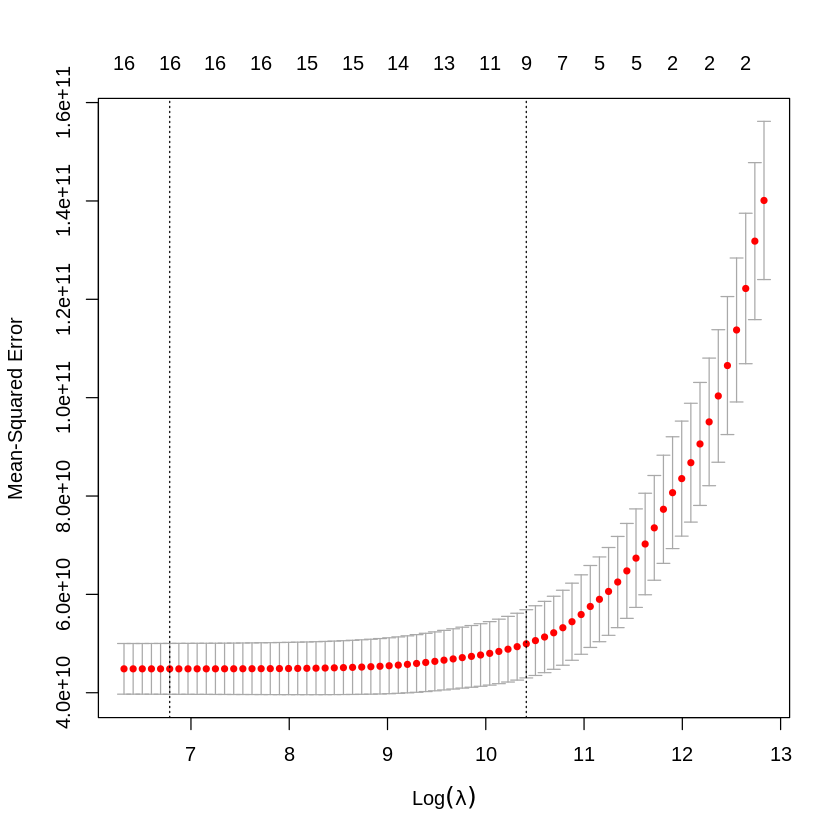

In [14]:
# Tuning the lambda value
options(repr.plot.width = 7, repr.plot.height = 7)

# Perform cross-validated elastic net
cv_model <- cv.glmnet(housing_X_train, housing_y_train, alpha = 0.7)

# Plot the cross-validated error as a function of log(lambda)
plot(cv_model)

In [15]:
# Obtain the lambda value with the minimum mean cross-validated error (cvm)
best_lambda <- cv_model$lambda.min
cat("Best Lambda Value:", best_lambda, "\n")

Best Lambda Value: 883.4397 


In [16]:
# fitting the optimized elastic net regression model

best_en_model <- glmnet(housing_X_train, housing_y_train, alpha = 0.7, lambda = best_lambda)

In [17]:
# examining the coefficients from elastic net regression fitting

en_coefficients <- coef(best_en_model)

coefficients_matrix <- as.matrix(en_coefficients)

coefficients_df <- as.data.frame(coefficients_matrix)

cat("Elastic Net Regression Coefficients with Alpha = 0.7, and Lambda = 883.4397","\n")
coefficients_df


Elastic Net Regression Coefficients with Alpha = 0.7, and Lambda = 883.4397 


,s0
,<dbl>
(Intercept),4.707051e+06
bedrooms,-3.062657e+04
bathrooms,4.234781e+04
sqft_living,1.370334e+02
sqft_lot,0.000000e+00
floors,-5.876194e+03
waterfront,6.081859e+05
view,4.749737e+04
condition,2.417018e+04


The variables selected by the model are:
* bedrooms
* bathrooms
* sqft_living
* floors
* waterfront
* view
* condition
* grade
* sqft_above
* yr_built
* yr_renovated
* zipcode
* lat
* long
* sqft_living15
* sqft_lot15

*Note: the issue of aliased coefficients is solved here as sqft_basement (the variable aliased with sqft_living an sqft_above) is not selected in the model.*

In [18]:
# Make predictions on the test set
predictions <- predict(best_en_model, newx = housing_X_test)

# Calculate Root Mean Squared Prediction Error on the test set
en_rmspe <- sqrt(mean((predictions - housing_y_test)^2))
cat("Root Mean Squared Prediction Error on Test Set With Elastic Net Regularization and Lambda Selection:", en_rmspe, "\n")

Root Mean Squared Prediction Error on Test Set With Elastic Net Regularization and Lambda Selection: 201112.2 


In [19]:
# Exploring the performance of the Full Model

full_house_OLS <- lm(price ~ ., 
                     training_housing
                     )

full_house_pred_OLS <- predict(full_house_OLS, newdata = testing_housing)


full_house_pred_OLS_RMSPE <- sqrt(mean((predicted - housing_y_test)^2))

cat("Root Mean Squared Prediction Error on Test Set With Full Model:", full_house_pred_OLS_RMSPE, "\n")

Warning message in predict.lm(full_house_OLS, newdata = testing_housing):
“prediction from a rank-deficient fit may be misleading”


Root Mean Squared Prediction Error on Test Set With Full Model: 210714.9 


In [20]:
# Building tibble summarizing/comparing the results of both models

RMSPE_models <- rbind(
    tibble(
    Model = "Elastic Net Regression Model",
    RMSPE = en_rmspe
    ),
    tibble(
    Model = "OLS Full Regression",
    RMSE = full_house_pred_OLS_RMSPE
    )
    )
RMSPE_models


ERROR: Error in match.names(clabs, names(xi)): names do not match previous names


# References

Jović, A., Brkić, K., & Bogunovic, N. (2015). A review of feature selection methods with Applications. *38th International Convention on Information and Communication Technology,
Electronics and Microelectronics (MIPRO)*, 1200-1205.

Y. -H. Chan, W. W. Y. Ng, D. S. Yeung and P. P. K. Chan, "Empirical comparison of forward and backward search strategies in L-GEM based feature selection with RBFNN," *2010 International Conference on Machine Learning and Cybernetics*, Qingdao, China, 2010, 1524-1527, doi: 10.1109/ICMLC.2010.5580821.

Zou, H., & Hastie, T. (2003). Regression shrinkage and selection via the elastic net, with applications to microarrays. *JR Stat Soc Ser B*, 67, 301-20.



